In [2]:
pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.7 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import re
from collections import Counter
import unidecode
import nltk
from nltk.stem import WordNetLemmatizer
import subprocess
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
tqdm.pandas()

#downloading nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
!nvidia-smi

Tue May 21 06:33:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import gzip
import json
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)


file_path = '/content/drive/MyDrive/BertReviewAnalysis/review-Kansas_10.json.gz'

json_objects = []

for json_obj in parse(file_path):
    json_objects.append(json_obj)

df = pd.DataFrame(json_objects)


In [6]:
df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,110174851715143039572,Hannah Johnston,1603469475914,4,Really cute store. All the staff are lovely. T...,None,None,0x87bf03987b89d0c3:0x9b3d137e7bfc045a
1,109469133033675413034,Flint Blankenship,1628280826510,4,Well...... The place is a 5-Star..... BUT..,None,None,0x87bf03987b89d0c3:0x9b3d137e7bfc045a
2,101132804334372412402,Sheryl Fields,1511648800146,2,Normally we really like stopping in and shoppi...,None,"{'time': 1511695775965, 'text': 'So sorry to d...",0x87bf03987b89d0c3:0x9b3d137e7bfc045a
3,114573410811170173535,Robert Gragg,1572660533736,4,Nice selection of antiques collectables and ho...,None,"{'time': 1572693100906, 'text': 'Thank you for...",0x87bf03987b89d0c3:0x9b3d137e7bfc045a
4,117268927797389286107,Jan Swan,1603471293093,4,Nice stuff,None,None,0x87bf03987b89d0c3:0x9b3d137e7bfc045a


In [7]:
df.shape

(3080115, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080115 entries, 0 to 3080114
Data columns (total 8 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   name     object
 2   time     int64 
 3   rating   int64 
 4   text     object
 5   pics     object
 6   resp     object
 7   gmap_id  object
dtypes: int64(2), object(6)
memory usage: 188.0+ MB


In [9]:
df = df[['user_id', 'text', 'rating']]

In [10]:
from sklearn.model_selection import train_test_split
df, remaining = train_test_split(df, random_state = 42, train_size = 0.3, stratify = df["rating"])  #using only 0.3% of the original data

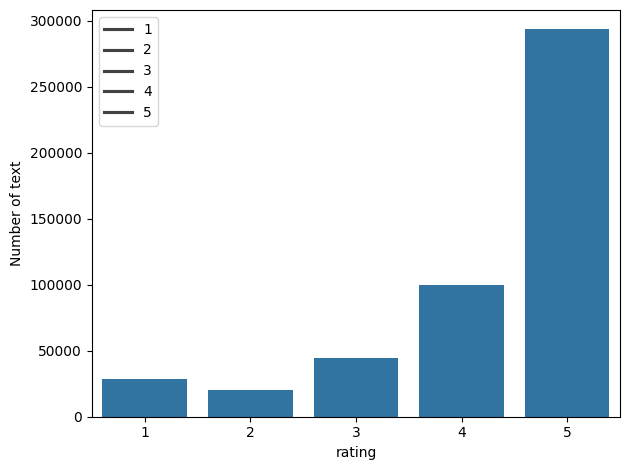

In [11]:
diff_of_gen = df.groupby(df['rating'])['text'].count().reset_index()

sns.barplot(x=diff_of_gen['rating'],y=diff_of_gen['text'])
plt.tight_layout()
plt.legend(diff_of_gen['rating'])
plt.ylabel('Number of text')
plt.show()

In [12]:
missing_values = df['text'].isnull().sum()

if missing_values > 0:
    df.dropna(subset=['text'], inplace=True)
    print(f"Dropped {missing_values} rows with missing 'text' values.")

if 'text' in df.columns:
    text_by_rating = {}
    for rating in range(1, 6):
        text_by_rating[rating] = ' '.join(df[df['rating'] == rating]['text'])
    for rating, text in text_by_rating.items():
        print(f"Text for rating {rating}:\n{text[:100]}...")
else:
    print("The 'text' column does not exist in the DataFrame.")

Dropped 437343 rows with missing 'text' values.
Text for rating 1:
Another FAIL. Always messing up my order. Slower then normal service. Staff stood around a while the...
Text for rating 2:
One of the slowest fast food restaurants I have ever been to. It consistently takes over 10 mins to ...
Text for rating 3:
I went to school here in the 90s when it was Cherokee Elementary. Sad because they are closing this ...
Text for rating 4:
Extremely fast service. Meal was great! Decent food for the price. Glad this exists, but they really...
Text for rating 5:
Fast friendly service with great food. Absolutely amazing food absolutely worth it . I used to go to...


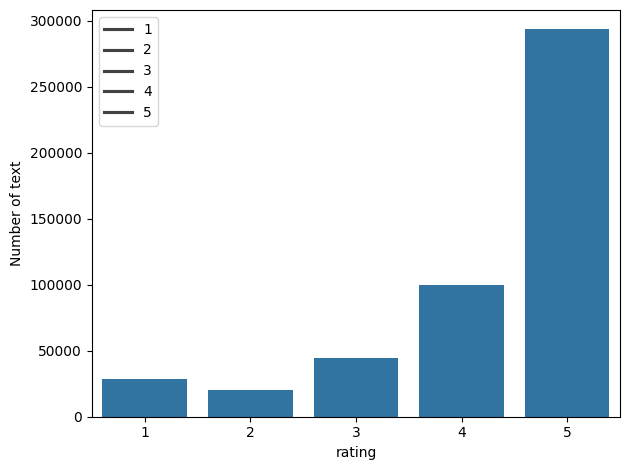

In [13]:
diff_of_gen = df.groupby(df['rating'])['text'].count().reset_index()
sns.barplot(x=diff_of_gen['rating'],y=diff_of_gen['text'])
plt.tight_layout()
plt.legend(diff_of_gen['rating'])
plt.ylabel('Number of text')
plt.show()

In [14]:
df.shape

(486691, 3)

In [15]:
text_1 = ' '.join(df[df['rating']==1]['text'])[0:df.shape[0]]
text_2= ' '.join(df[df['rating']==2]['text'])[0:df.shape[0]]
text_3 = ' '.join(df[df['rating']==3]['text'])[0:df.shape[0]]
text_4 = ' '.join(df[df['rating']==4]['text'])[0:df.shape[0]]
text_5 = ' '.join(df[df['rating']==5]['text'])[0:df.shape[0]]

In [128]:
text_cloud_1 = WordCloud().generate(text_1)
text_cloud_2= WordCloud().generate(text_2)
text_cloud_3= WordCloud().generate(text_3)
text_cloud_4= WordCloud().generate(text_4)
text_cloud_5= WordCloud().generate(text_5)

NameError: name 'WordCloud' is not defined

NameError: name 'text_cloud_1' is not defined

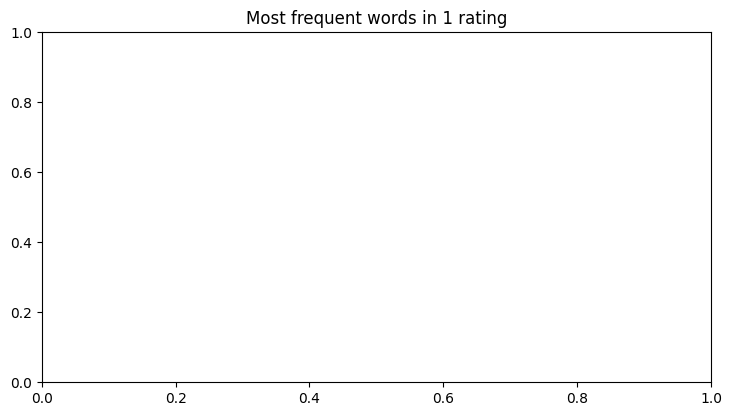

In [16]:
plt.figure(figsize=(19,10))

plt.subplot(2,2,1)
plt.title('Most frequent words in 1 rating')
plt.imshow(text_cloud_1, interpolation='bilinear')
plt.axis('off')

plt.subplot(2,2,2)
plt.title('Mostb frequent words in 2 rating')
plt.imshow(text_cloud_2, interpolation='bilinear')
plt.axis('off')

plt.show()

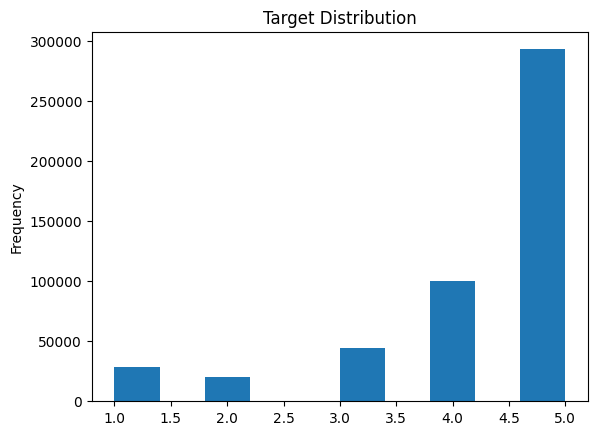

In [18]:
df.rating.plot(kind='hist', title = 'Target Distribution');

In [19]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <=2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [20]:
df['sentiment'] = df.rating.apply(to_sentiment)

In [21]:
class_names = ['negative','neutral','positive']

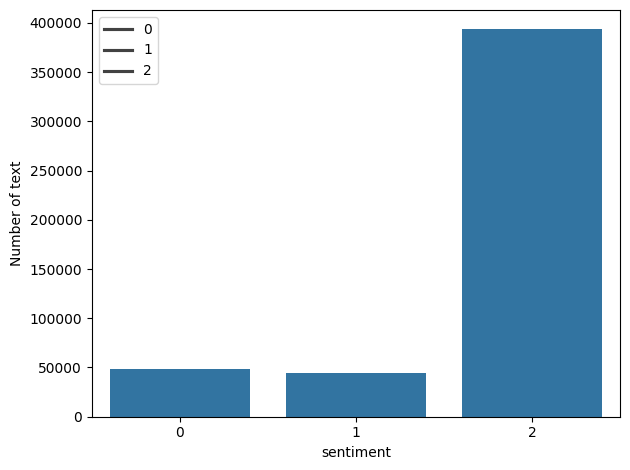

In [22]:
diff_of_gen = df.groupby(df['sentiment'])['text'].count().reset_index()

sns.barplot(x=diff_of_gen['sentiment'],y=diff_of_gen['text'])
plt.tight_layout()
plt.legend(diff_of_gen['sentiment'])
plt.ylabel('Number of text')
plt.show()

In [23]:
print(df['text'].str.len().max() , df['text'].str.len().min())

6250 1


<Axes: >

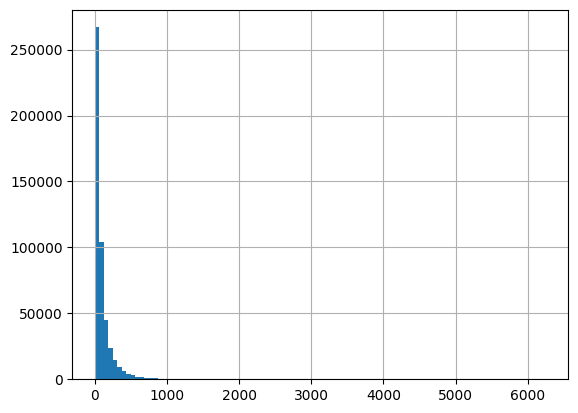

In [24]:
df['text'].str.len().hist(bins = 100)

In [25]:
ls_sp = sorted([char for char in set(' '.join([word for txt in df['text'] for word in txt])) if re.findall('[^A-Za-z]', char)])
ls_sp

['\t',
 '\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '\xa0',
 '¡',
 '¢',
 '£',
 '¥',
 '§',
 '©',
 '®',
 '¯',
 '°',
 '±',
 '²',
 '´',
 '¶',
 '·',
 '¹',
 '¼',
 '½',
 '¿',
 'À',
 'Á',
 'É',
 'Ì',
 'Í',
 'Ñ',
 'Ó',
 'Ô',
 '×',
 'Ú',
 'ß',
 'à',
 'á',
 'ã',
 'ä',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'î',
 'ï',
 'ñ',
 'ò',
 'ó',
 'ô',
 'õ',
 'ö',
 '÷',
 'ú',
 'û',
 'ü',
 'ý',
 'ā',
 'ą',
 'ć',
 'ċ',
 'ď',
 'ě',
 'İ',
 'ı',
 'ĺ',
 'ł',
 'ń',
 'ō',
 'ś',
 'ş',
 'š',
 'ů',
 'ź',
 'ż',
 'ž',
 'ơ',
 'ɖ',
 'ə',
 'ɛ',
 'ɢ',
 'ɦ',
 'ɨ',
 'ʀ',
 'ʄ',
 'ʊ',
 'ʋ',
 'ʍ',
 'ʏ',
 'ʟ',
 '́',
 '̃',
 'Ω',
 'π',
 'ω',
 'Є',
 'Ї',
 'А',
 'В',
 'Д',
 'Е',
 'З',
 'И',
 'К',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ч',
 'Я',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж'

In [26]:
[sent for sent in list(df['text']) if re.findall('[A-Z]+', sent)];

In [27]:
[sent for sent in list(df['text']) if '"' in sent];

In [28]:
top = Counter([item for sublist in df['text'] for item in sublist.split(' ')])
print(top.most_common(20))

[('and', 341042), ('the', 313778), ('to', 218395), ('a', 204150), ('I', 174508), ('was', 145961), ('is', 121424), ('of', 115307), ('', 110753), ('for', 109837), ('in', 94870), ('The', 72262), ('food', 70825), ('Great', 67753), ('it', 65981), ('my', 65916), ('good', 60425), ('with', 60329), ('have', 60239), ('they', 59020)]


In [29]:
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    text = text.lower() #Lower - Casing
    text = unidecode.unidecode(text) #Removing accents e.g ô
    text = re.sub('[^A-Za-z]'," ",text) #removing special characters
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split(" ") if word!=""]) #lemmatizing and remocing extra spaces
    return text

In [30]:
df['clean_text'] = df['text'].progress_apply(preprocess)

  0%|          | 0/486691 [00:00<?, ?it/s]

In [31]:
df.head()

,user_id,text,rating,sentiment,clean_text
619168,115234133247617433757,Extremely fast service. Meal was great!,4,2,extremely fast service meal wa great
3044953,100510469343202004867,Fast friendly service with great food.,5,2,fast friendly service with great food
184969,108411851823056113630,Absolutely amazing food absolutely worth it . ...,5,2,absolutely amazing food absolutely worth it i ...
445029,106105783922758017696,"I love the Family EyeCare Center, they are fr...",5,2,i love the family eyecare center they are frie...
317114,104375254911798683318,"Dr. Warwick is absolutely wonderful, as well a...",5,2,dr warwick is absolutely wonderful a well a hi...


In [32]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df['clean_text'], df['sentiment'],
                                                  stratify=df['sentiment'],
                                                  random_state=42,
                                                  test_size=0.2, shuffle=True)

In [33]:
label_encoder = LabelEncoder()
ytrain_encoded = label_encoder.fit_transform(ytrain)
yvalid_encoded = label_encoder.transform(yvalid)

In [34]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [35]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
xtrain.head()

2909979                              beautiful shopping mall
553916                              good neighbor hood store
1294255                                             yum yums
124429     unique home cooked food quail frog leg gizzard...
1379254    the place wa amazing staff wa awesome and frie...
Name: clean_text, dtype: object

In [43]:
# Create sentence and label lists
sentences_train = xtrain
sentences_test = xvalid

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_train = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_train]
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

In [44]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) #bert-base-uncased


tokenized_texts_train = [tokenizer.tokenize(sent) for sent in sentences_train]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]
print ("Tokenize the first sentence:")
print (tokenized_texts_train[0])

100%|██████████| 231508/231508 [00:00<00:00, 358058.51B/s]


Tokenize the first sentence:
['[CLS]', 'beautiful', 'shopping', 'mall', '[SEP]']


In [45]:
MAX_LEN = 64
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]

In [46]:
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [47]:
def to_attention(input_ids):
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [48]:
attention_masks_train = to_attention(input_ids_train)
attention_masks_test = to_attention(input_ids_test)

In [49]:
train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_test)
train_labels = torch.tensor(ytrain_encoded)
validation_labels = torch.tensor(yvalid_encoded)
train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_test)

In [50]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [52]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model = model.to(device)

100%|██████████| 407873900/407873900 [00:28<00:00, 14347850.14B/s]


In [53]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [54]:
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

In [55]:
# Function to calculate f1 score of our predictions vs labels
def flat_accuracy(preds, labels):
  #     pred_flat = np.argmax(preds, axis=1).flatten()
  #     labels_flat = labels.flatten()
  preds = preds.detach().cpu().numpy()
  return f1_score(labels.flatten(), np.argmax(preds, axis=1).flatten(), average='weighted')
  #return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [56]:
del sentences_train,sentences_test,tokenizer,tokenized_texts_train,tokenized_texts_test,input_ids_train,input_ids_test,attention_masks_train,attention_masks_test

In [162]:
t = []
train_loss_set = []

epochs = 2
torch.manual_seed(42)
for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())

        loss.backward()

        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Validation
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.29396066103448365


Epoch:  50%|█████     | 1/2 [1:32:31<1:32:31, 5551.05s/it]

Validation Accuracy: 0.8810941592848591
Train loss: 0.2500723367175767


Epoch: 100%|██████████| 2/2 [3:05:02<00:00, 5551.22s/it]

Validation Accuracy: 0.8872883495631335


In [162]:
import torch

# Assume 'model' is your PyTorch model
torch.save(model, 'model_complete.pth')

In [163]:
# Assume 'model' is your PyTorch model
torch.save(model, '/content/drive/MyDrive/pishingDetection/model_complete.pth')

In [164]:
# Assume 'model' is your PyTorch model
torch.save(model, '/content/drive/MyDrive/pishingDetection/model_complete2.pth')

In [57]:
import torch

# Load the entire model
model = torch.load('/content/drive/MyDrive/pishingDetection/model_complete2.pth')
model.eval()  # Set the model to evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [89]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for batch in tqdm(validation_dataloader, desc="Making predictions"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      y_pred = torch.softmax(logits, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
      # Put predictions on CPU for evaluation
      y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3042 [00:00<?, ?it/s]

In [90]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [91]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


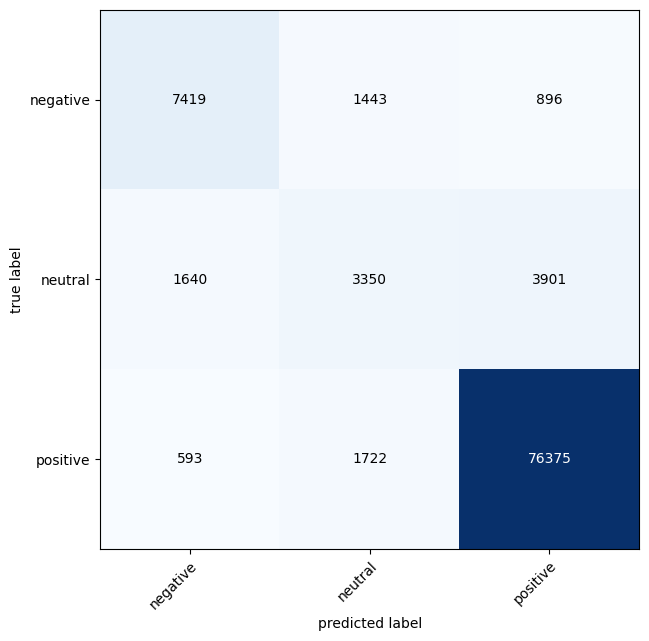

In [101]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
class_names = ['negative','neutral','positive']
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=validation_labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7),
    cmap=plt.cm.Blues
);

In [93]:
from sklearn.metrics import classification_report
print(classification_report(validation_labels, y_pred_tensor, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.76      9758
     neutral       0.51      0.38      0.43      8891
    positive       0.94      0.97      0.96     78690

    accuracy                           0.90     97339
   macro avg       0.74      0.70      0.72     97339
weighted avg       0.88      0.90      0.89     97339

